# Cross-Impact of Order Flow Imbalance in Equity Markets
Rama Cont, Mihai Cucuringu, and Chao Zhang

In [2]:
import databento as db
import pandas as pd
import numpy as np
import datetime
import itertools
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns

## Download from DataBento
*Use only once to save raw file*

In [38]:
# client = db.Historical("db-SHTimf6iQqxGSENt5NJp7te63MkjP")
# symbols = ["AAPL", "AMGN", "TSLA", "JPM", "XOM"]
# start_date = datetime.datetime(2024, 12, 1, 0, 0, 0)
# end_date = datetime.datetime(2025, 1, 3, 0, 0, 0)

# for symbol in symbols:
#     current_date = start_date
#     df = pd.DataFrame()

#     while current_date < end_date:
#         next_date = current_date + datetime.timedelta(days=1)  # Fetch daily data
#         print(current_date, next_date)

#         data = client.timeseries.get_range(
#             dataset="XNAS.ITCH",
#             symbols=symbol,
#             schema="mbp-10",
#             start=current_date.strftime("%Y-%m-%dT%H:%M:%S"),
#             end=next_date.strftime("%Y-%m-%dT%H:%M:%S"),
#         )

#         tmp_df = data.to_df()
#         current_date = next_date
#         if len(tmp_df) == 0: continue
#         tmp_df.to_csv(f"../data/raw/{symbol}_mbp-10_{tmp_df.index.max().strftime('%Y-%m-%d')}.csv")

2024-12-07 00:00:00 2024-12-08 00:00:00


C:\Users\Austin\AppData\Local\Temp\ipykernel_2316\3550041314.py:15: BentoWarning: No data found for the request you submitted. The request time range falls entirely inside a weekend.
  data = client.timeseries.get_range(


2024-12-08 00:00:00 2024-12-09 00:00:00


C:\Users\Austin\AppData\Local\Temp\ipykernel_2316\3550041314.py:15: BentoWarning: No data found for the request you submitted.
  data = client.timeseries.get_range(


2024-12-09 00:00:00 2024-12-10 00:00:00
2024-12-10 00:00:00 2024-12-11 00:00:00
2024-12-11 00:00:00 2024-12-12 00:00:00
2024-12-12 00:00:00 2024-12-13 00:00:00
2024-12-13 00:00:00 2024-12-14 00:00:00
2024-12-14 00:00:00 2024-12-15 00:00:00


C:\Users\Austin\AppData\Local\Temp\ipykernel_2316\3550041314.py:15: BentoWarning: No data found for the request you submitted. The request time range falls entirely inside a weekend.
  data = client.timeseries.get_range(


2024-12-15 00:00:00 2024-12-16 00:00:00


C:\Users\Austin\AppData\Local\Temp\ipykernel_2316\3550041314.py:15: BentoWarning: No data found for the request you submitted.
  data = client.timeseries.get_range(


2024-12-16 00:00:00 2024-12-17 00:00:00
2024-12-17 00:00:00 2024-12-18 00:00:00
2024-12-18 00:00:00 2024-12-19 00:00:00
2024-12-19 00:00:00 2024-12-20 00:00:00
2024-12-20 00:00:00 2024-12-21 00:00:00
2024-12-21 00:00:00 2024-12-22 00:00:00


C:\Users\Austin\AppData\Local\Temp\ipykernel_2316\3550041314.py:15: BentoWarning: No data found for the request you submitted. The request time range falls entirely inside a weekend.
  data = client.timeseries.get_range(


2024-12-22 00:00:00 2024-12-23 00:00:00


C:\Users\Austin\AppData\Local\Temp\ipykernel_2316\3550041314.py:15: BentoWarning: No data found for the request you submitted.
  data = client.timeseries.get_range(


2024-12-23 00:00:00 2024-12-24 00:00:00
2024-12-24 00:00:00 2024-12-25 00:00:00
2024-12-25 00:00:00 2024-12-26 00:00:00


C:\Users\Austin\AppData\Local\Temp\ipykernel_2316\3550041314.py:15: BentoWarning: No data found for the request you submitted.
  data = client.timeseries.get_range(


2024-12-26 00:00:00 2024-12-27 00:00:00
2024-12-27 00:00:00 2024-12-28 00:00:00
2024-12-28 00:00:00 2024-12-29 00:00:00


C:\Users\Austin\AppData\Local\Temp\ipykernel_2316\3550041314.py:15: BentoWarning: No data found for the request you submitted. The request time range falls entirely inside a weekend.
  data = client.timeseries.get_range(


2024-12-29 00:00:00 2024-12-30 00:00:00


C:\Users\Austin\AppData\Local\Temp\ipykernel_2316\3550041314.py:15: BentoWarning: No data found for the request you submitted.
  data = client.timeseries.get_range(


2024-12-30 00:00:00 2024-12-31 00:00:00
2024-12-31 00:00:00 2025-01-01 00:00:00
2025-01-01 00:00:00 2025-01-02 00:00:00


C:\Users\Austin\AppData\Local\Temp\ipykernel_2316\3550041314.py:15: BentoWarning: No data found for the request you submitted.
  data = client.timeseries.get_range(


2025-01-02 00:00:00 2025-01-03 00:00:00


## Illustration of the preprocessing workflow
*Skip to next subsection for production code*

Read raw data and preprocess

In [ ]:
# Read
symbol = 'TSLA'
dt_str = '2024-12-05'

mpb10df = pd.read_csv(f"../data/raw/{symbol}_mbp-10_{dt_str}.csv", index_col=0)
mpb10df.index = pd.to_datetime(mpb10df.index)
mpb10df.head(5)

,ts_event,rtype,publisher_id,instrument_id,action,side,depth,price,size,flags,...,ask_sz_08,bid_ct_08,ask_ct_08,bid_px_09,ask_px_09,bid_sz_09,ask_sz_09,bid_ct_09,ask_ct_09,symbol
ts_recv,,,,,,,,,,,,,,,,,,,,,
2024-12-05 09:00:00.032940084+00:00,2024-12-05 09:00:00.032773277+00:00,10,2,16244,A,N,0,392.76,14,130,...,0,0,0,NaN,NaN,0,0,0,0,TSLA
2024-12-05 09:00:00.033276942+00:00,2024-12-05 09:00:00.033110500+00:00,10,2,16244,A,A,1,960.00,25,130,...,0,0,0,NaN,NaN,0,0,0,0,TSLA
2024-12-05 09:00:00.127714470+00:00,2024-12-05 09:00:00.127545059+00:00,10,2,16244,A,B,0,356.24,100,130,...,0,0,0,NaN,NaN,0,0,0,0,TSLA
2024-12-05 09:00:00.127731067+00:00,2024-12-05 09:00:00.127562976+00:00,10,2,16244,A,A,0,356.72,100,130,...,0,0,0,NaN,NaN,0,0,0,0,TSLA
2024-12-05 09:00:00.128417526+00:00,2024-12-05 09:00:00.128250540+00:00,10,2,16244,C,A,0,356.72,100,130,...,0,0,0,NaN,NaN,0,0,0,0,TSLA


Calculate midprice $ P_{i,t} $

In [223]:
mpb10df['mid_price'] = mpb10df[['bid_px_00','ask_px_00']].sum(1) / 2

Following the definition of $ \text{OF}_{i,n}^{m,b} $ or $ \text{OF}_{i,n}^{m,a} $ in section 2.1 in the paper.

In [250]:
levels = [str(x).rjust(2, '0') for x in range(5)]
sides = ['bid', 'ask']
for level, side in itertools.product(levels, sides):
    price_col = f'{side}_px_{level}'
    qty_col   = f'{side}_ct_{level}'
    mpb10df[qty_col]   = mpb10df[qty_col].astype(int)
    mpb10df[f'prev_{price_col}'] = mpb10df[price_col].shift(1)
    mpb10df[f'prev_{qty_col}']   = mpb10df[qty_col].shift(1)
    mpb10df[f'{side}_of_{level}'] = 0.0
    if side == 'bid':
        mpb10df.loc[(mpb10df[price_col] > mpb10df[f'prev_{price_col}']), f'{side}_of_{level}'] = mpb10df.loc[(mpb10df[price_col] > mpb10df[f'prev_{price_col}']), qty_col]
        mpb10df.loc[(mpb10df[price_col] < mpb10df[f'prev_{price_col}']), f'{side}_of_{level}'] = -mpb10df.loc[(mpb10df[price_col] < mpb10df[f'prev_{price_col}']), qty_col]
        mpb10df.loc[(mpb10df[price_col] == mpb10df[f'prev_{price_col}']), f'{side}_of_{level}'] = mpb10df.loc[(mpb10df[price_col] == mpb10df[f'prev_{price_col}']), qty_col] - mpb10df.loc[(mpb10df[price_col] == mpb10df[f'prev_{price_col}']), f'prev_{qty_col}']
    else:
        mpb10df.loc[(mpb10df[price_col] > mpb10df[f'prev_{price_col}']), f'{side}_of_{level}'] = -mpb10df.loc[(mpb10df[price_col] > mpb10df[f'prev_{price_col}']), qty_col]
        mpb10df.loc[(mpb10df[price_col] < mpb10df[f'prev_{price_col}']), f'{side}_of_{level}'] = mpb10df.loc[(mpb10df[price_col] < mpb10df[f'prev_{price_col}']), qty_col]
        mpb10df.loc[(mpb10df[price_col] == mpb10df[f'prev_{price_col}']), f'{side}_of_{level}'] = mpb10df.loc[(mpb10df[price_col] == mpb10df[f'prev_{price_col}']), qty_col] - mpb10df.loc[(mpb10df[price_col] == mpb10df[f'prev_{price_col}']), f'prev_{qty_col}']

In [251]:
mpb10df.loc[f"{dt_str} 16:00":f"{dt_str} 16:00"]

,ts_event,rtype,publisher_id,instrument_id,action,side,depth,price,size,flags,...,bid_of_03,prev_ask_px_03,prev_ask_ct_03,ask_of_03,prev_bid_px_04,prev_bid_ct_04,bid_of_04,prev_ask_px_04,prev_ask_ct_04,ask_of_04
ts_recv,,,,,,,,,,,,,,,,,,,,,
2024-12-05 16:00:00.005944691+00:00,2024-12-05 16:00:00.005776268+00:00,10,2,16244,C,B,1,368.33,25,128,...,0.0,368.49,3.0,0.0,368.27,2.0,0.0,368.50,1.0,0.0
2024-12-05 16:00:00.005970467+00:00,2024-12-05 16:00:00.005803438+00:00,10,2,16244,A,A,0,368.43,25,130,...,0.0,368.49,3.0,0.0,368.27,2.0,0.0,368.50,1.0,0.0
2024-12-05 16:00:00.007515628+00:00,2024-12-05 16:00:00.007348126+00:00,10,2,16244,A,B,2,368.32,25,130,...,0.0,368.49,3.0,0.0,368.27,2.0,0.0,368.50,1.0,0.0
2024-12-05 16:00:00.013706271+00:00,2024-12-05 16:00:00.013536304+00:00,10,2,16244,C,B,0,368.33,25,130,...,-1.0,368.49,3.0,0.0,368.27,2.0,-3.0,368.50,1.0,0.0
2024-12-05 16:00:00.013715480+00:00,2024-12-05 16:00:00.013548425+00:00,10,2,16244,C,B,0,368.32,25,130,...,0.0,368.49,3.0,0.0,368.25,3.0,0.0,368.50,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-12-05 16:00:59.731485403+00:00,2024-12-05 16:00:59.731319201+00:00,10,2,16244,C,A,1,368.76,200,130,...,0.0,368.80,1.0,-1.0,368.64,1.0,0.0,368.82,1.0,-2.0
2024-12-05 16:00:59.731498041+00:00,2024-12-05 16:00:59.731331779+00:00,10,2,16244,A,A,2,368.80,200,130,...,0.0,368.82,1.0,0.0,368.64,1.0,0.0,368.83,2.0,0.0
2024-12-05 16:00:59.780146395+00:00,2024-12-05 16:00:59.779980482+00:00,10,2,16244,C,A,2,368.80,200,130,...,0.0,368.82,1.0,0.0,368.64,1.0,0.0,368.83,2.0,0.0


$ \text{OFI}_{i,t}^{m,h} $ and $ \text{ofi}_{i,t}^{m,h} $ calculation (Also section 2.1)

Below, $ h = \text{10 seconds} $

In [252]:
ofi_df = pd.DataFrame()
ofi_df[f'Q_{interval}'] = 0.0

interval = '1min'
for level in levels:
    ofi_df[f'OFI_{level}_{interval}'] = mpb10df[f'bid_of_{level}'].resample(interval).sum() - mpb10df[f'ask_of_{level}'].resample(interval).sum()
    ofi_df[f'Q_{interval}_{level}'] = (1/(2 * mpb10df['price'].resample(interval).count())) * (mpb10df[f'bid_ct_{level}'].resample(interval).sum() + mpb10df[f'ask_ct_{level}'].resample(interval).sum())

ofi_df[f'Q_{interval}'] = ofi_df[[f'Q_{interval}_{level}' for level in levels]].sum(axis=1) / len(levels)

for level in levels:
    ofi_df[f'ofi_{level}_{interval}'] = ofi_df[f'OFI_{level}_{interval}']/ofi_df[f'Q_{interval}']

In [253]:
ofi_df

,Q_1min,OFI_00_1min,Q_1min_00,OFI_01_1min,Q_1min_01,OFI_02_1min,Q_1min_02,OFI_03_1min,Q_1min_03,OFI_04_1min,Q_1min_04,ofi_00_1min,ofi_01_1min,ofi_02_1min,ofi_03_1min,ofi_04_1min
ts_recv,,,,,,,,,,,,,,,,
2024-12-05 09:00:00+00:00,1.113058,1.0,1.160501,-35.0,1.089771,-3.0,1.069641,14.0,1.119695,-13.0,1.125680,0.898426,-31.444912,-2.695278,12.577965,-11.679539
2024-12-05 09:01:00+00:00,1.172991,26.0,1.126331,24.0,1.103098,7.0,1.117619,-4.0,1.240077,1.0,1.277832,22.165553,20.460510,5.967649,-3.410085,0.852521
2024-12-05 09:02:00+00:00,1.407188,-28.0,1.285938,-24.0,1.217969,-10.0,1.357813,-29.0,1.505469,-21.0,1.668750,-19.897846,-17.055296,-7.106374,-20.608483,-14.923384
2024-12-05 09:03:00+00:00,1.520852,-32.0,1.751903,-17.0,1.215373,-26.0,1.409437,-21.0,1.614916,36.0,1.612633,-21.040833,-11.177942,-17.095677,-13.808046,23.670937
2024-12-05 09:04:00+00:00,1.460724,-30.0,1.963824,-16.0,1.325581,-13.0,1.206718,-9.0,1.346253,9.0,1.461240,-20.537768,-10.953476,-8.899699,-6.161330,6.161330
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-12-05 23:55:00+00:00,1.300000,0.0,1.000000,0.0,1.500000,0.0,1.000000,0.0,1.000000,0.0,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2024-12-05 23:56:00+00:00,1.244444,1.0,1.000000,2.0,1.361111,0.0,1.138889,1.0,1.000000,3.0,1.722222,0.803571,1.607143,0.000000,0.803571,2.410714
2024-12-05 23:57:00+00:00,1.300000,-1.0,1.027778,-2.0,1.472222,-1.0,1.000000,1.0,1.055556,-3.0,1.944444,-0.769231,-1.538462,-0.769231,0.769231,-2.307692


Integrated ofi ( $ \text{ofi}_{i,t}^{I,h} $ )

In [254]:
pca_cols = [f"ofi_{str(x).rjust(2, '0')}_{interval}" for x in range(5)]
data = ofi_df[pca_cols].to_numpy()
data[np.isnan(data)] = 0

scaler = StandardScaler()
data_standardized = scaler.fit_transform(data)
pca = PCA(n_components=1)
pca.fit(data_standardized)
w1 = pca.components_[0]
# ofi_mat = (w1 / np.abs(w1).sum()).T * data
ofi_df[f'ofi_I_{interval}'] = ((w1 / np.abs(w1).sum()).T * data).sum(1)

print(f"The first component explained {pca.explained_variance_ratio_[0]:.1%} of variance")

The first component explained 78.0% of variance


Calculate logarithmic returns ( $ r_{i,t}^{(h)} $ )

In [255]:
ofi_df[f'px_{interval}'] = mpb10df['mid_price'].resample(interval).last()
ofi_df[f'r_{interval}'] = np.log(1 + ofi_df[f'px_{interval}'].pct_change())

In [256]:
mpb10df[mpb10df['action'] == 'T']['size'].resample(interval).sum()

ts_recv
2024-12-05 09:00:00+00:00    1017
2024-12-05 09:01:00+00:00    1282
2024-12-05 09:02:00+00:00    1296
2024-12-05 09:03:00+00:00     188
2024-12-05 09:04:00+00:00     830
                             ... 
2024-12-05 23:55:00+00:00       0
2024-12-05 23:56:00+00:00      40
2024-12-05 23:57:00+00:00     165
2024-12-05 23:58:00+00:00      16
2024-12-05 23:59:00+00:00     203
Freq: min, Name: size, Length: 900, dtype: int64

In [257]:
ofi_df['volume'] = mpb10df[mpb10df['action'] == 'T']['size'].resample(interval).sum()
ofi_df['volume'] = ofi_df['volume'].fillna(0.0)
ofi_df['symbol'] = symbol

In [258]:
ofi_df.head()

,Q_1min,OFI_00_1min,Q_1min_00,OFI_01_1min,Q_1min_01,OFI_02_1min,Q_1min_02,OFI_03_1min,Q_1min_03,OFI_04_1min,...,ofi_00_1min,ofi_01_1min,ofi_02_1min,ofi_03_1min,ofi_04_1min,ofi_I_1min,px_1min,r_1min,volume,symbol
ts_recv,,,,,,,,,,,,,,,,,,,,,
2024-12-05 09:00:00+00:00,1.113058,1.0,1.160501,-35.0,1.089771,-3.0,1.069641,14.0,1.119695,-13.0,...,0.898426,-31.444912,-2.695278,12.577965,-11.679539,-6.586122,356.525,NaN,1017,TSLA
2024-12-05 09:01:00+00:00,1.172991,26.0,1.126331,24.0,1.103098,7.0,1.117619,-4.0,1.240077,1.0,...,22.165553,20.460510,5.967649,-3.410085,0.852521,9.729388,356.595,0.000196,1282,TSLA
2024-12-05 09:02:00+00:00,1.407188,-28.0,1.285938,-24.0,1.217969,-10.0,1.357813,-29.0,1.505469,-21.0,...,-19.897846,-17.055296,-7.106374,-20.608483,-14.923384,-15.891272,356.375,-0.000617,1296,TSLA
2024-12-05 09:03:00+00:00,1.520852,-32.0,1.751903,-17.0,1.215373,-26.0,1.409437,-21.0,1.614916,36.0,...,-21.040833,-11.177942,-17.095677,-13.808046,23.670937,-8.617137,356.345,-0.000084,188,TSLA
2024-12-05 09:04:00+00:00,1.460724,-30.0,1.963824,-16.0,1.325581,-13.0,1.206718,-9.0,1.346253,9.0,...,-20.537768,-10.953476,-8.899699,-6.161330,6.161330,-8.548544,356.085,-0.000730,830,TSLA


Final (relevant columns) data frame

In [259]:
keep_cols = ['symbol', f"px_{interval}", f"r_{interval}", 'volume']
keep_cols.extend([f'ofi_{l}_{interval}' for l in levels]) # ofi's
keep_cols.append(f'ofi_I_{interval}')
ofi_df[keep_cols].head()

,symbol,px_1min,r_1min,volume,ofi_00_1min,ofi_01_1min,ofi_02_1min,ofi_03_1min,ofi_04_1min,ofi_I_1min
ts_recv,,,,,,,,,,
2024-12-05 09:00:00+00:00,TSLA,356.525,NaN,1017,0.898426,-31.444912,-2.695278,12.577965,-11.679539,-6.586122
2024-12-05 09:01:00+00:00,TSLA,356.595,0.000196,1282,22.165553,20.460510,5.967649,-3.410085,0.852521,9.729388
2024-12-05 09:02:00+00:00,TSLA,356.375,-0.000617,1296,-19.897846,-17.055296,-7.106374,-20.608483,-14.923384,-15.891272
2024-12-05 09:03:00+00:00,TSLA,356.345,-0.000084,188,-21.040833,-11.177942,-17.095677,-13.808046,23.670937,-8.617137
2024-12-05 09:04:00+00:00,TSLA,356.085,-0.000730,830,-20.537768,-10.953476,-8.899699,-6.161330,6.161330,-8.548544


In [202]:
ofi_df[keep_cols].to_csv(f"../data/processed/{symbol}_mbp-10.csv")

## Preprocess data

In [1]:
dt_str = "2024-12-05"

In [260]:
def process_data(symbol, interval='10s', dt_str='2024-12-05'):
    # Load raw data
    mpb10df = pd.read_csv(f"../data/raw/{symbol}_mbp-10_{dt_str}.csv", index_col=0)
    mpb10df.index = pd.to_datetime(mpb10df.index)
    mpb10df['mid_price'] = mpb10df[['bid_px_00','ask_px_00']].sum(1) / 2

    # Calculate order flow for each level and side
    levels = [str(x).rjust(2, '0') for x in range(5)]
    sides = ['bid', 'ask']
    for level, side in itertools.product(levels, sides):
        price_col = f'{side}_px_{level}'
        qty_col   = f'{side}_ct_{level}'
        mpb10df[qty_col]   = mpb10df[qty_col].astype(int)
        mpb10df[f'prev_{price_col}'] = mpb10df[price_col].shift(1)
        mpb10df[f'prev_{qty_col}']   = mpb10df[qty_col].shift(1)
        mpb10df[f'{side}_of_{level}'] = 0.0 # initialize
        # Section 2.1 for order flow (OF) definition
        if side == 'bid':
            mpb10df.loc[(mpb10df[price_col] > mpb10df[f'prev_{price_col}']), f'{side}_of_{level}'] = mpb10df.loc[(mpb10df[price_col] > mpb10df[f'prev_{price_col}']), qty_col]
            mpb10df.loc[(mpb10df[price_col] < mpb10df[f'prev_{price_col}']), f'{side}_of_{level}'] = -mpb10df.loc[(mpb10df[price_col] < mpb10df[f'prev_{price_col}']), qty_col]
            mpb10df.loc[(mpb10df[price_col] == mpb10df[f'prev_{price_col}']), f'{side}_of_{level}'] = mpb10df.loc[(mpb10df[price_col] == mpb10df[f'prev_{price_col}']), qty_col] - mpb10df.loc[(mpb10df[price_col] == mpb10df[f'prev_{price_col}']), f'prev_{qty_col}']
        else:
            mpb10df.loc[(mpb10df[price_col] > mpb10df[f'prev_{price_col}']), f'{side}_of_{level}'] = -mpb10df.loc[(mpb10df[price_col] > mpb10df[f'prev_{price_col}']), qty_col]
            mpb10df.loc[(mpb10df[price_col] < mpb10df[f'prev_{price_col}']), f'{side}_of_{level}'] = mpb10df.loc[(mpb10df[price_col] < mpb10df[f'prev_{price_col}']), qty_col]
            mpb10df.loc[(mpb10df[price_col] == mpb10df[f'prev_{price_col}']), f'{side}_of_{level}'] = mpb10df.loc[(mpb10df[price_col] == mpb10df[f'prev_{price_col}']), qty_col] - mpb10df.loc[(mpb10df[price_col] == mpb10df[f'prev_{price_col}']), f'prev_{qty_col}']

    # Calculate OFI and normalized OFI
    ofi_df = pd.DataFrame()
    ofi_df[f'Q_{interval}'] = 0.0
    for level in levels:
        # Calculate OFI
        ofi_df[f'OFI_{level}_{interval}'] = mpb10df[f'bid_of_{level}'].resample(interval).sum() - mpb10df[f'ask_of_{level}'].resample(interval).sum()
        # Calculate normalized quantity
        ofi_df[f'Q_{interval}_{level}'] = (1/(2 * mpb10df['price'].resample(interval).count())) * (mpb10df[f'bid_ct_{level}'].resample(interval).sum() + mpb10df[f'ask_ct_{level}'].resample(interval).sum())
    # continue calculating normalized quantity
    ofi_df[f'Q_{interval}'] = ofi_df[[f'Q_{interval}_{level}' for level in levels]].sum(axis=1) / len(levels)
    # Calculate ofi
    for level in levels:
        ofi_df[f'ofi_{level}_{interval}'] = ofi_df[f'OFI_{level}_{interval}']/ofi_df[f'Q_{interval}']

    # Apply PCA to obtain integrated ofi
    pca_cols = [f"ofi_{str(x).rjust(2, '0')}_{interval}" for x in range(5)]
    data = ofi_df[pca_cols].to_numpy()
    data[np.isnan(data)] = 0
    
    scaler = StandardScaler()
    data_standardized = scaler.fit_transform(data)
    pca = PCA(n_components=1)
    pca.fit(data_standardized)
    w1 = pca.components_[0]
    ofi_df[f'ofi_I_{interval}'] = ((w1 / np.abs(w1).sum()).T * data).sum(1)

    ofi_df[f'px_{interval}'] = mpb10df['mid_price'].resample(interval).last()
    ofi_df[f'r_{interval}'] = np.log(1 + ofi_df[f'px_{interval}'].pct_change())
    ofi_df['volume'] = mpb10df[mpb10df['action'] == 'T']['size'].resample(interval).sum()
    ofi_df['volume'] = ofi_df['volume'].fillna(0.0)
    ofi_df['symbol'] = symbol

    # Select relevant columns
    keep_cols = ['symbol', f"px_{interval}", f"r_{interval}", 'volume']
    keep_cols.extend([f'ofi_{l}_{interval}' for l in levels]) # ofi's
    keep_cols.append(f'ofi_I_{interval}')

    ofi_df[keep_cols].to_csv(f"../data/processed/{symbol}_mbp-10_{dt_str}.csv")
    return ofi_df[keep_cols]

In [261]:
import pandas_market_calendars
nyse = pandas_market_calendars.get_calendar('NYSE')

In [262]:
start_date = '2024-12-01'
end_date = '2025-01-02'
dt_strs = [x.strftime('%Y-%m-%d') for x in nyse.valid_days(start_date=start_date, end_date=end_date)]

In [263]:
symbols = ["AAPL", "AMGN", "TSLA", "JPM", "XOM"]
# symbols = ["XOM"]
interval = '1min'

res = pd.DataFrame()
for symbol in symbols:
    for dt_str in dt_strs:
        tmp = process_data(symbol, interval=interval, dt_str=dt_str)
        tmp = tmp.loc[f'{dt_str} 14:45':f'{dt_str} 20:45'] # 14:45~20:45 chosen (expln next section)
        res = pd.concat([res, tmp], axis=0)

C:\Users\Austin\AppData\Local\Temp\ipykernel_76868\2212694274.py:54: FutureWarning: The default fill_method='pad' in Series.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  ofi_df[f'r_{interval}'] = np.log(1 + ofi_df[f'px_{interval}'].pct_change())
C:\Users\Austin\AppData\Local\Temp\ipykernel_76868\2212694274.py:54: FutureWarning: The default fill_method='pad' in Series.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  ofi_df[f'r_{interval}'] = np.log(1 + ofi_df[f'px_{interval}'].pct_change())
C:\Users\Austin\AppData\Local\Temp\ipykernel_76868\2212694274.py:54: FutureWarning: The default fill_method='pad' in Series.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading

In [264]:
res.describe()

,px_1min,r_1min,volume,ofi_00_1min,ofi_01_1min,ofi_02_1min,ofi_03_1min,ofi_04_1min,ofi_I_1min
count,39255.000000,39710.000000,3.971000e+04,39255.000000,39255.000000,39255.000000,39255.000000,39255.000000,39710.000000
mean,257.416479,-0.000002,9.844544e+03,-3.640151,-1.550381,-1.088865,-1.848538,-1.207913,-1.916883
std,98.656651,0.000796,3.108174e+04,83.606084,58.829283,63.926371,63.660867,71.207027,55.630167
min,104.850000,-0.013893,0.000000e+00,-1782.836937,-1391.984693,-1812.028268,-2432.602805,-5223.528312,-886.649843
25%,239.142500,-0.000291,1.076000e+03,-12.913774,-11.509679,-11.053898,-11.591585,-11.403224,-10.423647
50%,249.590000,0.000000,2.986500e+03,0.000000,0.207100,0.000000,0.000000,0.000000,0.000000
75%,275.545000,0.000288,1.129475e+04,11.705604,11.437501,11.171130,11.426467,11.460015,10.196822
max,487.955000,0.013041,3.579327e+06,1400.130856,1181.336825,1125.925009,1308.337278,2460.796876,763.145066


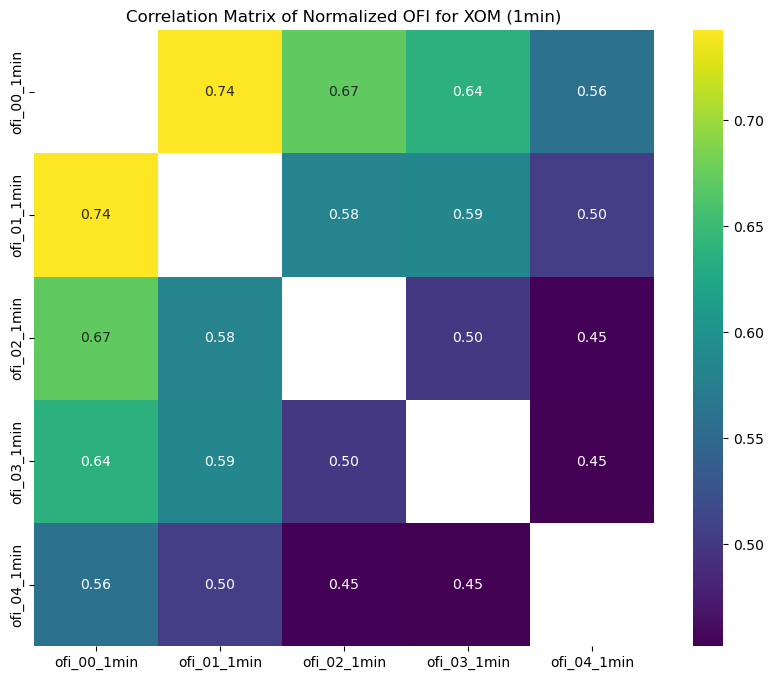

In [265]:
# Calculate correlation matrix
corr_cols = [f"ofi_{str(x).rjust(2, '0')}_{interval}" for x in range(5)]
corr_matrix = res.loc[:,corr_cols].corr()

# Remove diagonal (where value is one)
np.fill_diagonal(corr_matrix.values, np.nan)

# Plotting the heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap="viridis", cbar=True)
plt.title(f"Correlation Matrix of Normalized OFI for {symbol} ({interval})")
plt.show()

In [266]:
corr_cols = [f"ofi_{str(x).rjust(2, '0')}_{interval}" for x in range(5)]
res[corr_cols].corr()

,ofi_00_1min,ofi_01_1min,ofi_02_1min,ofi_03_1min,ofi_04_1min
ofi_00_1min,1.000000,0.742321,0.670958,0.637813,0.561850
ofi_01_1min,0.742321,1.000000,0.582857,0.586690,0.504880
ofi_02_1min,0.670958,0.582857,1.000000,0.499597,0.454275
ofi_03_1min,0.637813,0.586690,0.499597,1.000000,0.452015
ofi_04_1min,0.561850,0.504880,0.454275,0.452015,1.000000


## Section 3 - Contemporaneous Cross-Impact

In [267]:
import statsmodels.formula.api as sm
from sklearn.model_selection import train_test_split 

Merge all stock csv

In [268]:
symbols = ["AAPL", "AMGN", "TSLA", "JPM", "XOM"]
df = pd.DataFrame()

for symbol in symbols:
    inner = pd.DataFrame()
    for dt_str in dt_strs:
        tmp = pd.read_csv(f"../data/processed/{symbol}_mbp-10_{dt_str}.csv", index_col=0)
        tmp.index = pd.to_datetime(tmp.index)
        # tmp = tmp.loc[f'{dt_str} 14:45':f'{dt_str} 20:45']
        tmp.columns = [f"{symbol}_{c}" for c in tmp.columns]
        inner = pd.concat([inner, tmp], axis=0)

    df = pd.concat([df, inner], axis=1)

We must note that before/during market open and after/during market close, the market behaves differently from other times. Therefore, we only focus data between **14:45~20:45 (UTC)** for the following analysis.

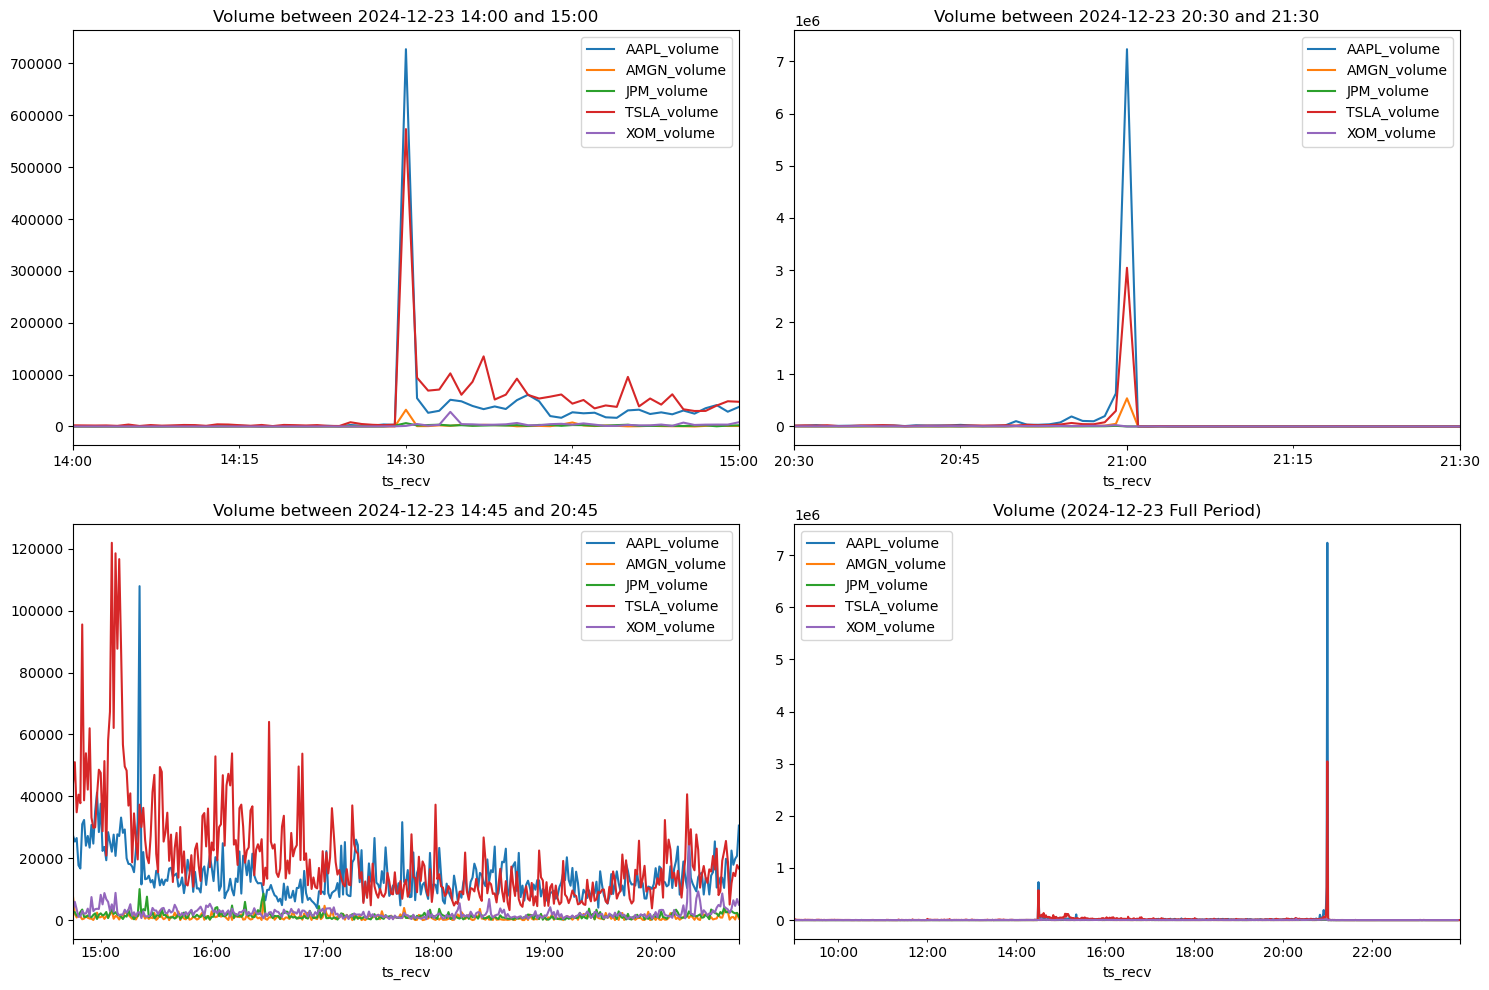

In [269]:
dt_str = dt_strs[15]
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# Plot 1
df.loc[
    f'{dt_str} 14:00':f'{dt_str} 15:00',
    ['AAPL_volume', 'AMGN_volume', 'JPM_volume', 'TSLA_volume', 'XOM_volume']
].plot(ax=axes[0, 0])
axes[0, 0].set_title(f'Volume between {dt_str} 14:00 and 15:00')

# Plot 2
df.loc[
    f'{dt_str} 20:30':f'{dt_str} 21:30',
    ['AAPL_volume', 'AMGN_volume', 'JPM_volume', 'TSLA_volume', 'XOM_volume']
].plot(ax=axes[0, 1])
axes[0, 1].set_title(f'Volume between {dt_str} 20:30 and 21:30')

# Plot 3
df.loc[
    f'{dt_str} 14:45':f'{dt_str} 20:45',
    ['AAPL_volume', 'AMGN_volume', 'JPM_volume', 'TSLA_volume', 'XOM_volume']
].plot(ax=axes[1, 0])
axes[1, 0].set_title(f'Volume between {dt_str} 14:45 and 20:45')

# Plot 4
df.loc[dt_str:dt_str,['AAPL_volume', 'AMGN_volume', 'JPM_volume', 'TSLA_volume', 'XOM_volume']].plot(ax=axes[1, 1])
axes[1, 1].set_title(f'Volume ({dt_str} Full Period)')

plt.tight_layout()
plt.show()

In [270]:
df

,AAPL_symbol,AAPL_px_1min,AAPL_r_1min,AAPL_volume,AAPL_ofi_00_1min,AAPL_ofi_01_1min,AAPL_ofi_02_1min,AAPL_ofi_03_1min,AAPL_ofi_04_1min,AAPL_ofi_I_1min,...,XOM_symbol,XOM_px_1min,XOM_r_1min,XOM_volume,XOM_ofi_00_1min,XOM_ofi_01_1min,XOM_ofi_02_1min,XOM_ofi_03_1min,XOM_ofi_04_1min,XOM_ofi_I_1min
ts_recv,,,,,,,,,,,,,,,,,,,,,
2024-12-02 09:00:00+00:00,AAPL,236.990,NaN,469.0,8.048632,0.000000,6.036474,-18.109422,0.000000,-2.037957,...,XOM,118.245,NaN,40.0,2.324723,3.487085,9.298893,-4.649446,1.162362,2.307412
2024-12-02 09:01:00+00:00,AAPL,236.880,-0.000464,852.0,-0.805031,21.735849,-4.025157,-18.515723,0.805031,-0.745823,...,XOM,117.880,-0.003092,14.0,-3.594203,-8.086957,-7.188406,-0.898551,0.000000,-3.939313
2024-12-02 09:02:00+00:00,AAPL,236.890,0.000042,298.0,-12.800000,13.600000,-10.400000,2.400000,3.200000,-0.063041,...,XOM,117.860,-0.000170,0.0,2.713864,-1.809243,-10.855457,5.427729,-9.046214,-2.747580
2024-12-02 09:03:00+00:00,AAPL,236.840,-0.000211,60.0,0.854159,-13.666542,26.478926,-17.083178,-2.562477,-4.612450,...,XOM,117.885,0.000212,0.0,0.000000,-0.977444,-1.954887,0.000000,-8.796992,-2.370033
2024-12-02 09:04:00+00:00,AAPL,236.865,0.000106,101.0,5.858441,-10.043042,33.476805,-24.270684,-5.858441,-4.511024,...,XOM,118.090,0.001737,8.0,-1.944134,2.916201,0.972067,0.972067,-11.664804,-1.763983
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-01-02 23:55:00+00:00,AAPL,243.165,-0.000123,11.0,-0.683371,-0.683371,-1.025057,0.683371,-7.175399,-1.903928,...,XOM,NaN,0.000000,0.0,NaN,NaN,NaN,NaN,NaN,0.000000
2025-01-02 23:56:00+00:00,AAPL,243.190,0.000103,34.0,0.322581,0.322581,2.258065,0.322581,0.322581,0.481528,...,XOM,107.385,-0.000047,0.0,-0.833333,-0.833333,-0.833333,-1.666667,-0.833333,-1.005847
2025-01-02 23:57:00+00:00,AAPL,243.190,0.000000,0.0,0.000000,0.312500,0.000000,0.000000,0.000000,0.071268,...,XOM,NaN,0.000000,0.0,NaN,NaN,NaN,NaN,NaN,0.000000


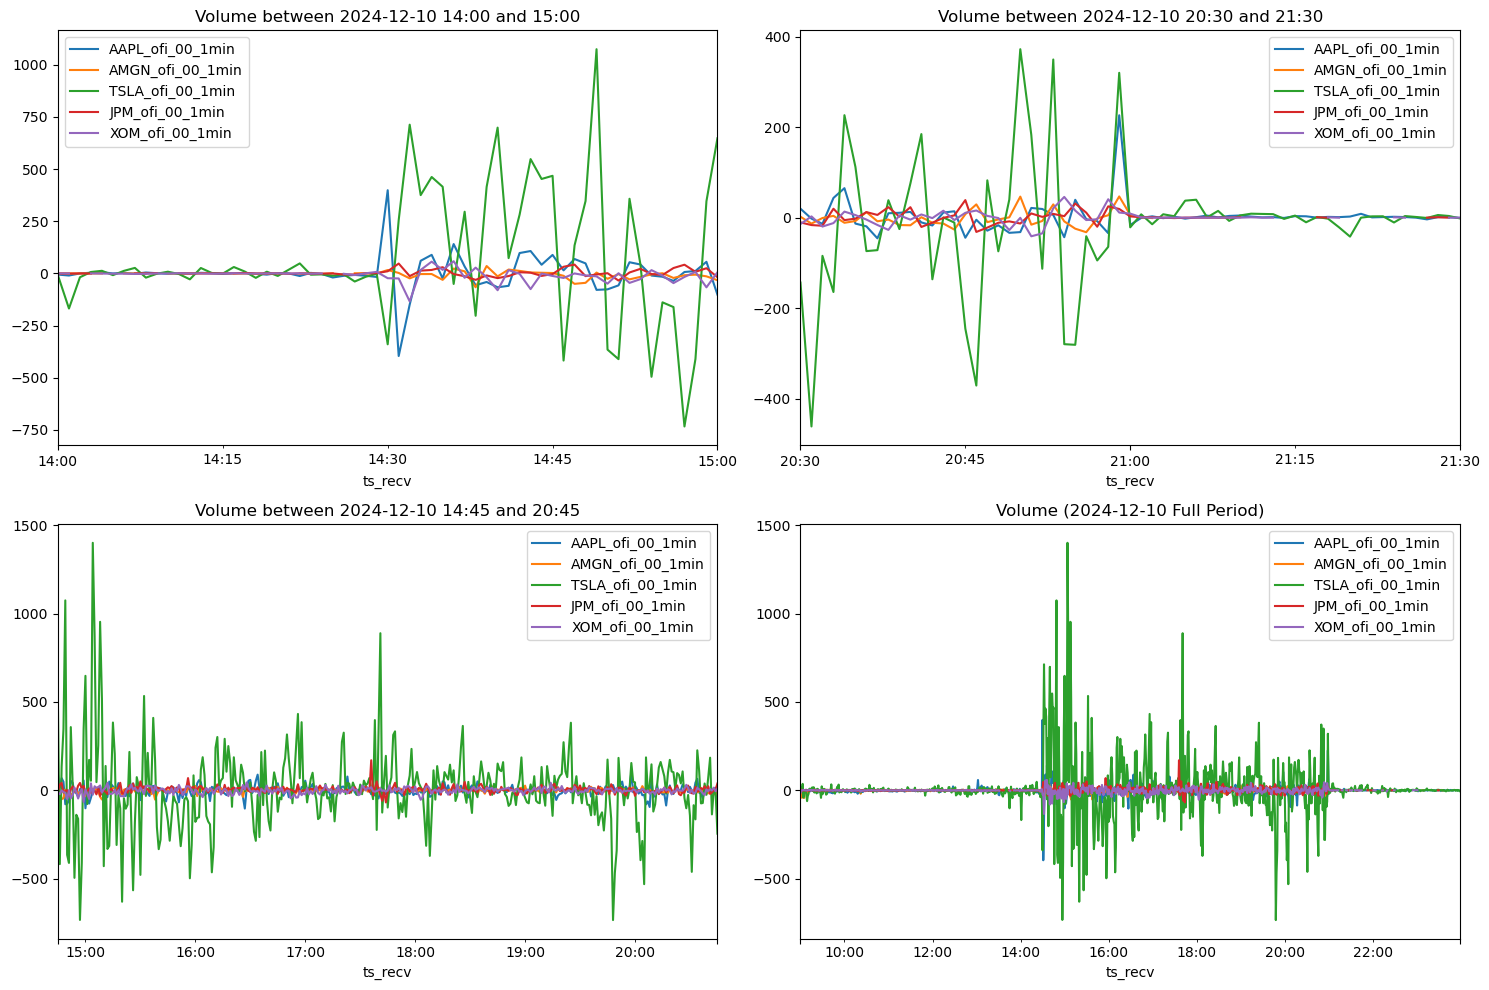

In [271]:
dt_str = dt_strs[6]
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# Plot 1
df.loc[
    f'{dt_str} 14:00':f'{dt_str} 15:00',
    [f'{s}_ofi_00_1min' for s in symbols]
].plot(ax=axes[0, 0])
axes[0, 0].set_title(f'Volume between {dt_str} 14:00 and 15:00')

# Plot 2
df.loc[
    f'{dt_str} 20:30':f'{dt_str} 21:30',
    [f'{s}_ofi_00_1min' for s in symbols]
].plot(ax=axes[0, 1])
axes[0, 1].set_title(f'Volume between {dt_str} 20:30 and 21:30')

# Plot 3
df.loc[
    f'{dt_str} 14:45':f'{dt_str} 20:45',
    [f'{s}_ofi_00_1min' for s in symbols]
].plot(ax=axes[1, 0])
axes[1, 0].set_title(f'Volume between {dt_str} 14:45 and 20:45')

# Plot 4
df.loc[
    dt_str:dt_str,
    [f'{s}_ofi_00_1min' for s in symbols]
].plot(ax=axes[1, 1])
axes[1, 1].set_title(f'Volume ({dt_str} Full Period)')

plt.tight_layout()
plt.show()

In [272]:
symbols = ["AAPL", "AMGN", "TSLA", "JPM", "XOM"]
df = pd.DataFrame()

for symbol in symbols:
    inner = pd.DataFrame()
    for dt_str in dt_strs:
        tmp = pd.read_csv(f"../data/processed/{symbol}_mbp-10_{dt_str}.csv", index_col=0)
        tmp.index = pd.to_datetime(tmp.index)
        tmp = tmp.loc[f'{dt_str} 14:45':f'{dt_str} 20:45']
        tmp.columns = [f"{symbol}_{c}" for c in tmp.columns]
        inner = pd.concat([inner, tmp], axis=0)

    df = pd.concat([df, inner], axis=1)

In [273]:
interval = df.columns[1].split('_')[-1]

### Price Impact of best-level OFIs ( $ \textbf{PI}^{[1]} $ )

In [274]:
def regress(df, dependent_var, independent_vars):
    formula = f"{dependent_var} ~ {' + '.join(independent_vars)}"

    model = sm.ols(formula, data=df).fit()
    return model

In [275]:
symbol = 'AAPL'

independent_vars = [f'{symbol}_ofi_00_{interval}']  # Add more as needed
model = regress(df, f'{symbol}_r_{interval}', independent_vars)

print(model.summary())

                            OLS Regression Results                            
Dep. Variable:            AAPL_r_1min   R-squared:                       0.504
Model:                            OLS   Adj. R-squared:                  0.504
Method:                 Least Squares   F-statistic:                     8043.
Date:                Wed, 08 Jan 2025   Prob (F-statistic):               0.00
Time:                        00:45:57   Log-Likelihood:                 52955.
No. Observations:                7911   AIC:                        -1.059e+05
Df Residuals:                    7909   BIC:                        -1.059e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
Intercept         6.657e-06   3.37e-06  

### Price Impact of integrated OFIs ( $ \textbf{PI}^{I} $ )

In [276]:
symbol = "AAPL"

independent_vars = [f'{symbol}_ofi_I_{interval}']  # Add more as needed
model = regress(df, f'{symbol}_r_{interval}', independent_vars)

print(model.summary())

                            OLS Regression Results                            
Dep. Variable:            AAPL_r_1min   R-squared:                       0.825
Model:                            OLS   Adj. R-squared:                  0.825
Method:                 Least Squares   F-statistic:                 3.731e+04
Date:                Wed, 08 Jan 2025   Prob (F-statistic):               0.00
Time:                        00:46:14   Log-Likelihood:                 57303.
No. Observations:                7942   AIC:                        -1.146e+05
Df Residuals:                    7940   BIC:                        -1.146e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
Intercept        1.211e-05      2e-06     

### Cross-Impact of best-level OFIs ( $ \textbf{CI}^{[1]} $ )

OLS

In [277]:
this_symbol = "AAPL"

independent_vars = [f'{symbol}_ofi_00_{interval}' for symbol in symbols]  # Add more as needed
model = regress(df, f'{this_symbol}_r_{interval}', independent_vars)

print(model.summary())

                            OLS Regression Results                            
Dep. Variable:            AAPL_r_1min   R-squared:                       0.525
Model:                            OLS   Adj. R-squared:                  0.524
Method:                 Least Squares   F-statistic:                     1715.
Date:                Wed, 08 Jan 2025   Prob (F-statistic):               0.00
Time:                        01:00:44   Log-Likelihood:                 52180.
No. Observations:                7779   AIC:                        -1.043e+05
Df Residuals:                    7773   BIC:                        -1.043e+05
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
Intercept         9.382e-06   3.38e-06  

LASSO with CV (detailed statistics to be implemented with R)

In [49]:
from sklearn.linear_model import Lasso, LassoCV

In [130]:
this_symbol = "AAPL"
dependent_var = f'{this_symbol}_r_{interval}'
independent_vars = [f'{symbol}_ofi_00_{interval}' for symbol in symbols]  # Add more as needed

X = df[independent_vars].values
y = df[dependent_var].values

model = LassoCV(cv=5, random_state=0)  # 5-fold cross-validation
model.fit(X, y)

print(f"Selected alpha: {model.alpha_}")
for i, var in enumerate(independent_vars):
    print(f"{var}: {model.coef_[i]}")

Selected alpha: 0.0016566291143948171
AAPL_ofi_00_1min: 1.593041865902379e-06
AMGN_ofi_00_1min: 0.0
TSLA_ofi_00_1min: -0.0
JPM_ofi_00_1min: 0.0
XOM_ofi_00_1min: -0.0


In [132]:
model = Lasso(alpha=0.001)
model.fit(df[independent_vars], df[dependent_var])
# model.summary()
print(model.intercept_)
print(model.coef_)
print(model.alpha)

0.00011931677864061625
[ 1.97431717e-06  0.00000000e+00 -0.00000000e+00  0.00000000e+00
 -0.00000000e+00]
0.001


### Cross-Impact of Integrated OFIs ( $ \textbf{CI}^{I} $ )

In [278]:
[f"ofi_{str(x).rjust(2, '0')}_{interval}" for x in range(5)]

['ofi_00_1min', 'ofi_01_1min', 'ofi_02_1min', 'ofi_03_1min', 'ofi_04_1min']

In [279]:
this_symbol = "AAPL"

independent_vars = [f'{symbol}_ofi_I_{interval}' for symbol in symbols]  # Add more as needed
model = regress(df, f'{this_symbol}_r_{interval}', independent_vars)

print(model.summary())

                            OLS Regression Results                            
Dep. Variable:            AAPL_r_1min   R-squared:                       0.828
Model:                            OLS   Adj. R-squared:                  0.828
Method:                 Least Squares   F-statistic:                     7630.
Date:                Wed, 08 Jan 2025   Prob (F-statistic):               0.00
Time:                        01:01:01   Log-Likelihood:                 57377.
No. Observations:                7942   AIC:                        -1.147e+05
Df Residuals:                    7936   BIC:                        -1.147e+05
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
Intercept        1.143e-05   1.99e-06     

In [280]:
this_symbol = "AAPL"

X = df[independent_vars].values
y = df[dependent_var].values

model = LassoCV(cv=5, random_state=0)  # 5-fold cross-validation
model.fit(X, y)

print(f"Selected alpha: {model.alpha_}")
for i, var in enumerate(independent_vars):
    print(f"{var}: {model.coef_[i]}")

Selected alpha: 4.147788936816818e-05
AAPL_ofi_I_1min: 1.311148326321613e-05
AMGN_ofi_I_1min: 1.9677777689189975e-07
TSLA_ofi_I_1min: 3.208791858201553e-08
JPM_ofi_I_1min: 1.38123243384122e-06
XOM_ofi_I_1min: -0.0


In [281]:
model = Lasso(alpha=0.0005)
model.fit(df[independent_vars], df[dependent_var])
# model.summary()
print(model.intercept_)
print(model.coef_)
print(model.alpha)

1.2237405439889937e-05
[1.27084921e-05 0.00000000e+00 4.76196328e-08 0.00000000e+00
 0.00000000e+00]
0.0005
